# Performance tests

* [This Coral TPU project](https://github.com/foobar167/junkyard/tree/master/coral_tpu)

Useful links:
* [TensorFlow models on the Edge TPU](https://coral.ai/docs/edgetpu/models-intro/#compatibility-overview)
* [Colab tutorials for Coral](https://github.com/google-coral/tutorials)
* [Retrain MobileNet V2 classifier for the Edge TPU (TF2)](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb)

## Helper functions

In [1]:
import os
import math
import json
import shutil
import zipfile
import tarfile
import platform

from PIL import Image
# from IPython.display import display
from matplotlib import pyplot as plt


def extract(fname):
    """ Extract data from archive file """
    if fname.endswith(".tar.gz") or fname.endswith(".tgz"):
        ref = tarfile.open(fname, mode="r:gz")
    elif fname.endswith(".tar"):
        ref = tarfile.open(fname, mode="r:")
    elif fname.endswith(".tar.bz2") or fname.endswith(".tbz"):
        ref = tarfile.open(fname, mode="r:bz2")
    elif fname.endswith(".zip"):
        ref = zipfile.ZipFile(fname, mode="r")
    ref.extractall()
    ref.close()


def tgz(sdir):
    """ Make *.tgz archive file from source dir """
    sdir = sdir.strip("\\/")  # remove all leading and trailing slashes
    fname = os.path.basename(sdir)
    fname_tgz = fname + ".tgz"
    fname_tar_gz = fname + ".tar.gz"
    archive1 = os.path.join(os.path.dirname(sdir), fname_tgz)
    archive2 = os.path.join(os.path.dirname(sdir), fname_tar_gz)
    # Delete dir or file if exists
    if os.path.exists(archive1) and os.path.isdir(archive1):
        shutil.rmtree(archive1, ignore_errors=False)
    elif os.path.exists(archive1) and os.path.isfile(archive1):
        os.remove(archive1)
    # Make *.tag.gz file
    with tarfile.open(fname_tar_gz, "w:gz") as tar:
        tar.add(sdir, arcname=fname)
    # Reaneme *.tar.gz to *.tgz
    os.rename(archive2, archive1)


EXT = (".jpg", ".jpeg", ".png", ".gif")  # valid image file extensions


def separator(info=""):
    """ Separator string with information """
    sep1 = "-"
    sep2 = " "
    sep_length = 70  # separator length
    l1 = (sep_length - len(info)) // 2 - len(sep2)  # number of dashes
    if len(info) == 0:
        s = sep1 * sep_length
        return f"{s}"
    elif l1 <= 0:
        return info
    else:
        l2 = (sep_length - len(info)) % 2  # 0 or 1 extra space
        s1 = sep1 * l1
        s2 = info + " " * l2
        return f"{s1}{sep2}{s2}{sep2}{s1}"


def get_image_names(path):
    """ Get all image names in a directory """
    names = []
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            names.append(f)
    return names


def get_image_names2(path):
    """ Get all image names in a directory and
        return the list of (label, name) """
    dataset = []  # list of (label, name)
    classes = {}  # dict of classes
    for root, dirs, files in os.walk(path, topdown=True):
        for name in files:
            if name.lower().endswith(EXT):
                label = os.path.basename(root)
                name = os.path.join(root, name)
                dataset.append((int(label), name))
                classes[label] = label
    return dataset, classes


def get_images(path):
    """ Get all images in a directory """
    images = {}
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            images[f] = Image.open(os.path.join(path, f)).convert("RGB")
    return images


def get_images2(lst):
    """ Get all images from the list (label, name) and
        return dictoonary of images """
    images = {}
    for label, name in lst:
        if name.lower().endswith(EXT):
            images[name] = Image.open(name).convert("RGB")
    return images


# def show(images, cmap="viridis"):
#     """ Show images with matplotlib. Default color map is "viridis" """
#     for key, value in images.items():
#         value = value.resize((100, 100))
#         display(value)


def show(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    fig = plt.figure(figsize=(12, 8))  # create figure
    l = len(images)
    rows = math.floor(math.sqrt(l))
    cols = math.ceil(l / rows)
    for i, (key, value) in enumerate(images.items(), 1):
        fig.add_subplot(rows, cols, i)  # add a subplot
        plt.imshow(value, cmap=cmap); plt.axis("off"); plt.title(key)
    plt.show()


def load_labels(idx=1):
    """ Get ImageNet dataset labels from URL """
    url = "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/data/imagenet_class_index.json"
    name = os.path.basename(url)
    if not os.path.exists(name):
        output = os.system(f"wget {url} -O {name}")
        if output != 0:
            print(f"Error when downloading URL: {url}")
            return None
    CLASS_INDEX = json.load(open(name))
    labels = []
    for i in range(len(CLASS_INDEX)):
        # CLASS_INDEX example: "753": ["n04040759", "radiator"]
        labels.append(CLASS_INDEX[str(i)][idx])
    return labels


_INFO = {
    "Linux": "lscpu | grep 'Model name:'",
    "Windows": "wmic cpu get name, numberofcores",
}[platform.system()]


print(separator("CPU info"))
print(os.popen(cmd=_INFO).read())  # get info about the hardware (CPU)

------------------------------ CPU info ------------------------------
Model name:                      Cortex-A55
Model name:                      Cortex-A76
Model name:                      Cortex-A55



## Classify with different models

Take different neural network architectures for [ImageNet](https://www.image-net.org/) from TF repository: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

--2024-04-14 01:15:23--  https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/parrot.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596977 (583K) [image/jpeg]
Saving to: ‘parrot.jpg’

     0K .......... .......... .......... .......... ..........  8%  167K 3s
    50K .......... .......... .......... .......... .......... 17%  175K 3s
   100K .......... .......... .......... .......... .......... 25%  149K 3s
   150K .......... .......... .......... .......... .......... 34% 96.6K 3s
   200K .......... .......... .......... .......... .......... 42%  241K 2s
   250K .......... .......... .......... .......... .......... 51%  164K 2s
   300K .......... .......... .......... .......... .......... 60%  195K 1s
   350K .......... ..

cat.jpg
human.jpg
panda.jpg
parrot.jpg


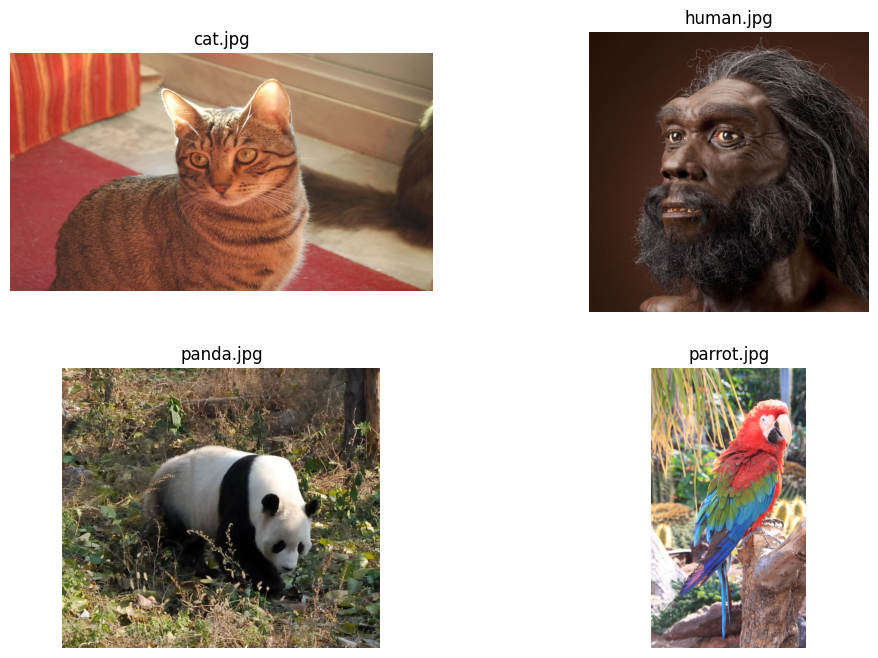

In [2]:
# Import necessary libraries
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.applications as apps

from IPython.display import display
# from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.models import save_model, load_model


# Create "temp" directory and make it the current dir
TEMP_DIR = "temp"
THIS_DIR = os.path.dirname(os.path.realpath("__file__"))  # path to the current dir
if os.path.basename(THIS_DIR) == TEMP_DIR:  # already in the "temp" directory
    pass
else:
    if not os.path.isdir(TEMP_DIR):  # directory does not exist
        os.makedirs(TEMP_DIR)
    os.chdir(os.path.join(THIS_DIR, TEMP_DIR))  # make path to "temp" dir the current path


# Download test images and show them
urls = {"parrot.jpg": "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/parrot.jpg",
        "cat.jpg":    "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/cat.jpg",
        "panda.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/panda.jpg",
        "human.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/human.jpg",
}
img_paths = []
for name, url in urls.items():
    output = os.system(f"wget {url} -O {name}")
    if output == 0:
        img_paths.append(name)
    else:
        print(f"Error when downloading URL: {url}")
print("\n".join(get_image_names(".")))  # print image names
show(get_images("."))  # show images


# Set constants
BATCH_SIZE = 100
IMAGE_SHAPE = (224, 224, 3)  # do not change it
IMAGE_SHAPE2 = (299, 299, 3)  # do not change it
RESIZE_METHOD = Image.BILINEAR
# RESIZE_METHOD2 = tf.image.ResizeMethod.BILINEAR
RESIZE_METHOD2 = tf.compat.v1.image.ResizeMethod.BILINEAR
BENCHMARK_IMG = "parrot.jpg"
COUNT = 22  # number of runs for benchmark
TOP_K = 3  # get first top results
OPTIMIZER = "rmsprop"
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
METRICS = ["accuracy"]
IMAGENETV2_PATH = "imagenetv2-matched-frequency-format-val"  # path to ImageNet-v2 dataset


# Models dictionary in the format: key: [name, "", norm, shape]
net = {
    "MobileNetV2": ["mobilenetv2_1.0_224",  # v[0] model filename
                    "placeholder",          # v[1] placeholder for variables
                    True,                   # v[2] normalize image or not
                    IMAGE_SHAPE],           # v[3] input image shape
    "MobileNetV3Large": ["mobilenetv3large_1.0_224", "placeholder", False, IMAGE_SHAPE],
    "MobileNetV3Small": ["mobilenetv3small_1.0_224", "placeholder", False, IMAGE_SHAPE],
    "DenseNet121": ["densenet121_224", "placeholder", True, IMAGE_SHAPE],
    "InceptionV3": ["inceptionv3_299", "placeholder", True, IMAGE_SHAPE2],
    "ResNet50": ["resnet50_224", "placeholder", False, IMAGE_SHAPE],    # norm==False, check it for diff. TF
    "ResNet101": ["resnet101_224", "placeholder", False, IMAGE_SHAPE],  # norm==False, check it for diff. TF
    "ResNet50V2": ["resnet50v2_224", "placeholder", True, IMAGE_SHAPE],
    "ResNet101V2": ["resnet101v2_224", "placeholder", True, IMAGE_SHAPE],
    # "VGG16": ["vgg16_224", "placeholder", False, IMAGE_SHAPE],          # norm==False, check it for diff. TF
    "Xception": ["xception_299", "placeholder", True, IMAGE_SHAPE2],
}

## Unzip and prepare archive with models
Unzip and prepare archive with models from the previous step called
"[Get data for tests](https://colab.research.google.com/drive/1YLFMUxzHETAuOK69X_YQ_ei913W5cTMo)".

File "all_files.zip" should be in the "data" subfolder.
Change path to your archive with model files if necessary.

In [3]:
%%script echo "Skip this cell"
extract("../data/all_files.zip")  # extract from "*.zip" archive

Skip this cell


## Run speed benchmarks for TF

In [4]:
def preprocess_input(img_path, normalize, im_shape):
    """ Preprocess input. Analogue of
        "tf.keras.applications.mobilenet_v*.preprocess_input" function """
    img = Image.open(img_path).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.asarray(img)  # convert from PIL Image to NumPy
    if normalize:  # normalize image
        img = img / 127.5 - 1.0
    else:  # don't normalize image
        pass
    img = np.expand_dims(img, axis=0)  # (224,224,3) to (1,224,224,3)
    return img


def decode_predictions(results):
    """ Decode predictions. Analogue of
        "tf.keras.applications.mobilenet_v*.decode_predictions" function """
    labels = load_labels()
    top = results.argsort()[-TOP_K:][::-1]  # get first top k results
    # Return list of tuples (label, probability)
    return [(labels[i], f"{results[i]:.4f}") for i in top]


def average_runtime(runtime):
    """ Show average runtime """
    if len(runtime) > 5:
        runtime = runtime[2:]  # skip the first 2 values
    elif len(runtime) > 1:
        runtime = runtime[1:]  # skip the 1st value
    average = f"{np.average(runtime):>6.1f} ms"
    print(f"Average time of the last {len(runtime)} runs: {average}")
    return average


def run_unconverted(img_path, model_name, normalize, im_shape, unpack=True):
    """ Run unconverted TF model for image """
    path = os.path.join(TEMP_DIR, model_name)
    if unpack:
        extract(path + ".tgz")  # extract from "*.tgz" archive
    # Should be "compile=False" for different TF versions
    # model = tf.keras.layers.TFSMLayer(model_name, call_endpoint="serving_default")  # Keras3
    model = load_model(model_name, compile=False)  # not supported in Keras3
    # Set optimizer, loss and metrics for evaluation if necessary
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    print(separator("INFERENCE TIME"))
    img = preprocess_input(img_path, normalize, im_shape)  # preprocess image
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        model(img, training=False)  # predict
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")
    print(separator("RESULTS"))
    results = model(img, training=False)  # predict
    del model
    results = results.numpy()[0]  # convert from tf to numpy
    print(decode_predictions(results))
    return average_runtime(runtime)


def benchmark(img_path, run):
    """ Run benchmarks """
    for k, v in net.items():
        print(f"\n{separator(v[0])}\n")
        v[1] = run(img_path=img_path, model_name=v[0], normalize=v[2], im_shape=v[3])

    print(f"\n" f"Speeds for '{img_path}' image are:")
    for k, v in net.items():
        print(f"{k:17} {v[1]}")

In [5]:
benchmark(BENCHMARK_IMG, run_unconverted)


------------------------ mobilenetv2_1.0_224  ------------------------

--------------------------- INFERENCE TIME ---------------------------
402.0 ms
199.9 ms
182.2 ms
181.7 ms
186.8 ms
177.1 ms
189.6 ms
180.0 ms
185.1 ms
180.4 ms
191.2 ms
182.5 ms
186.2 ms
177.7 ms
204.5 ms
211.7 ms
186.7 ms
185.5 ms
192.3 ms
203.4 ms
185.2 ms
220.1 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9413'), ('lorikeet', '0.0059'), ('bee_eater', '0.0024')]
Average time of the last 20 runs:  189.5 ms

---------------------- mobilenetv3large_1.0_224 ----------------------

--------------------------- INFERENCE TIME ---------------------------
347.1 ms
227.7 ms
234.1 ms
235.7 ms
227.4 ms
227.3 ms
235.8 ms
231.5 ms
234.7 ms
227.6 ms
230.6 ms
232.6 ms
231.9 ms
229.6 ms
236.9 ms
229.0 ms
234.8 ms
228.4 ms
228.9 ms
231.5 ms
231.7 ms
230.6 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9773'), ('bee_eater', '0.0018'), ('lorikeet',

## Download the ImageNet-v2 dataset
Download and unarchivate the [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2)
dataset **manually** to make performance tests for CPU and TPU uniform.

(511, 'imagenetv2-matched-frequency-format-val/511/08e5cb3277f4571a8e6065bf3d03fd3132592ffc.jpeg')
(511, 'imagenetv2-matched-frequency-format-val/511/6cbdaa9e5da6a4950d7e1f8dfd3ac1d9676bcb9f.jpeg')
(511, 'imagenetv2-matched-frequency-format-val/511/4f30117a69e333a7ccc6f47b700e380a686141db.jpeg')
(511, 'imagenetv2-matched-frequency-format-val/511/1fe0b04663d48d9d0740a74f7b84055fd9a6bc99.jpeg')
(511, 'imagenetv2-matched-frequency-format-val/511/196dc284f6a80c9830d44ae76493b7a489335362.jpeg')
(511, 'imagenetv2-matched-frequency-format-val/511/715efaceca1108315fbd378040efe3ad3367a133.jpeg')


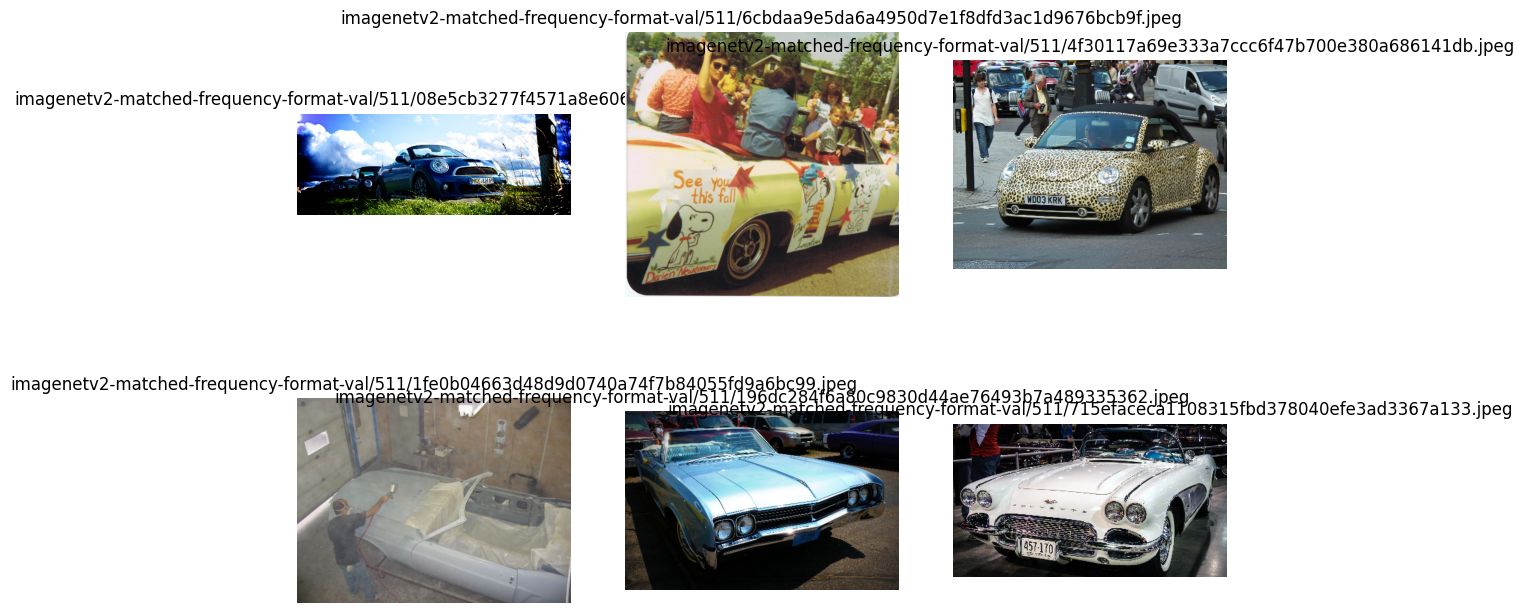

Number of classes: 1000
Number of images: 10000


In [3]:
# # %%script echo "Skip this cell"
# # Download ImageNet-v2 dataset
# DS, info = tfds.load(
#     "imagenet_v2", split="test", with_info=True,
#     # shuffle_files=True,
#     shuffle_files=False,
# )

# # Obtaining dataset information.
# print(f"Number of classes: {info.features['label'].num_classes}")
# # print(f"Classes: {info.features['label'].names}")
# print(f"Number of images: {len(DS)}")

# # Visualize dataset images. Can show only <= 9 images
# _ = tfds.show_examples(DS.take(12), info)


# Prepare the ImageNet-v2 dataset manually without TF
DS, CLASSES = get_image_names2(IMAGENETV2_PATH)

example = DS[:6]
print(*example, sep="\n")
imgs = get_images2(example)
show(imgs)  # visualize dataset images
print(f"Number of classes: {len(CLASSES)}")
print(f"Number of images: {len(DS)}")

## Run speed benchmarks for TF Lite

In [15]:
def run_converted(img_path, model_name, normalize, im_shape, ext=".tflite"):
    """ Run converted TF Lite model for image """
    model_name += ext  # use "*.tflite" files
    print(model_name)

    interpreter = tf.lite.Interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    height = input_details["shape"][1]  # NxHxWxC or [1, 224, 224, 3], H:1, W:2
    width = input_details["shape"][2]
    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    norm, mean = 127.5, 127.5
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # Image data must go through two transforms before running inference:
    #     1. normalization: f = (input - mean) / norm
    #     2. quantization: q = f / scale + zero_point
    # The following code combines the two steps as such:
    #     q = (input - mean) / (norm * scale) + zero_point
    #
    # However, if norm * scale equals 1, and mean - zero_point equals 0, the input
    #   does not need any preprocessing (but in practice, even if the results are
    #   very close to 1 and 0, it is probably okay to skip preprocessing for better
    #   efficiency; we use 1e-5 below instead of absolute zero).
    #
    # There are following options:
    #   | No. | Normalization | Quantization | Details          |
    #   | --- | ------------- | ------------ | ---------------- |
    #   | 1   | yes           | no           |                  |
    #   | 2   | no            | no           |                  |
    #   | 3   | no            | yes          |                  |
    #   | 4   | yes           | yes          | No preprocessing |
    #   | 5   | yes           | yes          |                  |
    img = Image.open(img_path).resize((width, height), RESIZE_METHOD)
    # 1. Normalization - yes. Quantization - no.
    if normalize and (scale.size == 0 or zero_point.size == 0):
        print("- 1 -")
        img = (np.asarray(img) - mean) / norm
    # 2. Normalization - no. Quantization - no.
    elif (not normalize) and (scale.size == 0 or zero_point.size == 0):
        print("- 2 -")
        pass
    # 3. Normalization - no. Quantization - yes.
    elif (not normalize):
        print("- 3 -")
        img = np.asarray(img) / scale + zero_point
    # 4. Norm - yes. Quant - yes. No preprocessing.
    elif abs(scale * norm - 1) < 1e-5 and abs(int(mean) - zero_point) < 1e-5:
        print("- 4 -")
        pass
    # 5. Normalization - yes. Quantization - yes.
    else:
        print("- 5 -")
        img = (np.asarray(img) - mean) / (norm * scale) + zero_point
        np.clip(img, 0, 255, out=img)  # clip values to [0, 255]. Not sure if this is necessary

    img = np.asarray(img, dtype=dtype)  # convert to necessary type
    img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
    interpreter.set_tensor(input_details["index"], img)

    print(separator("INFERENCE TIME"))
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        interpreter.invoke()  # predict using TF Lite
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")

    print(separator("RESULTS"))
    # interpreter.get_tensor() copies data, but interpreter.tensor() avoids copying data
    results = interpreter.tensor(output_details["index"])().flatten()

    # De-quantize, if necessary
    if output_details["quantization"][0] and \
       np.issubdtype(output_details["dtype"], np.integer):
        print(" - de-quantize -")
        # Usually scale == 1/256 and zero_point == 0
        scale, zero_point = output_details["quantization"]
        # Always convert to np.int64 to avoid overflow on subtraction.
        results = scale * (results.astype(np.int64) - zero_point)

    # Clear resources to prevent error: "Segmentation fault (core dumped)"
    del interpreter

    print(decode_predictions(results))
    return average_runtime(runtime)

### Run TF Lite without quantization

In [8]:
# Run TF Lite without quantization
benchmark(BENCHMARK_IMG, run_converted)


------------------------ mobilenetv2_1.0_224  ------------------------

mobilenetv2_1.0_224.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
25.0 ms
24.1 ms
22.6 ms
23.0 ms
22.9 ms
22.6 ms
22.9 ms


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


22.7 ms
23.2 ms
23.5 ms
23.0 ms
24.9 ms
22.6 ms
22.8 ms
22.9 ms
22.5 ms
22.5 ms
23.1 ms
23.9 ms
23.7 ms
22.4 ms
22.4 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9413'), ('lorikeet', '0.0059'), ('bee_eater', '0.0024')]
Average time of the last 20 runs:   23.0 ms

---------------------- mobilenetv3large_1.0_224 ----------------------

mobilenetv3large_1.0_224.tflite
- 2 -
--------------------------- INFERENCE TIME ---------------------------
19.3 ms
18.0 ms
18.1 ms
18.2 ms
18.0 ms
18.1 ms
18.1 ms
18.1 ms
18.1 ms
18.1 ms
18.3 ms
19.8 ms
18.9 ms
18.6 ms
18.1 ms
18.1 ms
18.1 ms
18.1 ms
18.1 ms
18.1 ms
18.1 ms
18.6 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9773'), ('bee_eater', '0.0018'), ('lorikeet', '0.0011')]
Average time of the last 20 runs:   18.3 ms

---------------------- mobilenetv3small_1.0_224 ----------------------

mobilenetv3small_1.0_224.tflite
- 2 -
--------------------------- INFERENCE T

### Run TF Lite with uint8 quantization

In [16]:
# Run TF Lite with uint8 quantization
run_it = lambda img_path, model_name, normalize, im_shape: run_converted(img_path, model_name, normalize, im_shape, ext="_int8.tflite")
benchmark(BENCHMARK_IMG, run_it)


------------------------ mobilenetv2_1.0_224  ------------------------

mobilenetv2_1.0_224_int8.tflite
- 4 -
--------------------------- INFERENCE TIME ---------------------------
12.6 ms
11.7 ms
11.8 ms
11.7 ms
11.9 ms
11.9 ms
11.7 ms
11.8 ms
11.9 ms
11.6 ms
11.6 ms
11.7 ms
11.7 ms
11.6 ms
11.6 ms
11.6 ms
11.7 ms
11.7 ms
11.9 ms
11.7 ms
11.6 ms
11.6 ms
------------------------------ RESULTS  ------------------------------
 - de-quantize -
[('macaw', '0.9297'), ('bee_eater', '0.0039'), ('lorikeet', '0.0039')]
Average time of the last 20 runs:   11.7 ms

---------------------- mobilenetv3large_1.0_224 ----------------------

mobilenetv3large_1.0_224_int8.tflite
- 3 -
--------------------------- INFERENCE TIME ---------------------------
20.8 ms
20.6 ms
20.6 ms
20.6 ms
20.7 ms
20.7 ms
21.0 ms
20.8 ms
20.6 ms
20.6 ms
20.6 ms
20.6 ms
20.6 ms
20.5 ms
20.7 ms
20.9 ms
21.1 ms
20.9 ms
20.6 ms
20.5 ms
20.6 ms
20.6 ms
------------------------------ RESULTS  ------------------------------
 - de

## Estimate accuracy and speed on ImageNet-v2 dataset

In [5]:
def prepare(name, normalize, im_shape):
    """ Prepare datapoint (label, name) and return (label, image) tuple """
    # Open and resize the image
    img = Image.open(name).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.float32(img)  # convert from uint8 to float32
    if normalize:  # normalize
        img = img / 127.5 - 1.0
    else:  # don't normalize
        pass
    return img


def evaluate(dataset, model_name, normalize, im_shape, ext):
    """ TFLite model evaluation function """
    model_name += ext  # use "*_int8_edgetpu.tflite" files
    print(ext)

    # calculate on CPU
    interpreter = tf.lite.Interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # De-quantization is not necessary, because took max value without accuracy
    quant = False  # quantization
    if scale.size == 0 or zero_point.size == 0:
        pass
    else:
        # print("quantization - yes")
        quant = True

    true_labels = []
    predictions = []
    total = len(dataset)
    start_time = time.time()

    # Process the dataset
    for i, (label, name) in enumerate(dataset):
        if i % 300 == 0:
            print(f"\r" f"Evaluated {i} from {total}",
                  f" in {(time.time() - start_time):.0f} sec", end="")

        img = prepare(name, normalize, im_shape)

        # Image can go through quantization before running inference:
        #     quantization: q = f / scale + zero_point
        if quant:
            img = img / scale + zero_point
            np.clip(img, 0, 255, out=img)  # clip values to [0, 255]

        img = np.array(img, dtype=dtype)  # convert to necessary type
        img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
        interpreter.set_tensor(input_details["index"], img)
        interpreter.invoke()  # predict
        results = interpreter.tensor(output_details["index"])().flatten()
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    # Finish processing the dataset
    print("\r", end="")
    del interpreter
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} sec {' '*40}" f"\n")


def evaluate_tf(dataset, model_path, normalize, im_shape):
    """ TF model evaluation function.
        Evaluate every image by hand. """
    print("tf")
    model = load_model(model_path)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    true_labels = []
    predictions = []
    total = len(dataset)
    start_time = time.time()

    # Process the dataset
    for i, (label, name) in enumerate(dataset):
        if i % 300 == 0:
            print(f"\r" f"Evaluated {i} from {total}",
                  f" in {(time.time() - start_time):.0f} sec", end="")
        img = prepare(name, normalize, im_shape)
        img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
        results = model(img, training=False)  # predict
        results = results.numpy()[0]  # convert from tf to numpy
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    # Finish processing the dataset
    print("\r", end="")
    del model
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} sec {' '*40}" f"\n")

### Run short preliminary tests

In [7]:
def performance_tests(n):
    start_time = time.time()
    for k, v in net.items():
        print(separator(v[0]))
        evaluate_tf(DS[:n], v[0], v[2], v[3])
        for e in [".tflite", "_int8.tflite",]:
            evaluate(DS[:n], v[0], v[2], v[3], ext=e)
    stop_time = time.time()
    print(f"Runtime: {(stop_time - start_time):.0f} seconds")

In [11]:
# Run short preliminary tests
performance_tests(50)

------------------------ mobilenetv2_1.0_224  ------------------------
tf
Accuracy: 44.0 %; time: 10.6 sec                                         

.tflite
Accuracy: 44.0 %; time: 1.4 sec                                         

_int8.tflite
Accuracy: 42.0 %; time: 0.9 sec                                         

---------------------- mobilenetv3large_1.0_224 ----------------------
tf
Accuracy: 40.0 %; time: 12.0 sec                                         

.tflite
Accuracy: 40.0 %; time: 1.2 sec                                         

_int8.tflite
Accuracy: 10.0 %; time: 1.3 sec                                         

---------------------- mobilenetv3small_1.0_224 ----------------------
tf
Accuracy: 36.0 %; time: 8.6 sec                                         

.tflite
Accuracy: 36.0 %; time: 0.6 sec                                         

_int8.tflite
Accuracy: 22.0 %; time: 0.5 sec                                         

-------------------------- densenet121_224  ---

### Run on ImageNet-v2 10000 images
* Runtime ≈ ??? hours for Desktop
* Runtime ≈ ??? hours for CoolPi
* Runtime ≈ ??? hours for Pi4

Accuracy and speed for **Cool Pi 4 Model B** during run on Coral Edge TPU:
| Model name | TF acc, % | TF speed, sec | TFLite acc, % | TFLite speed, sec | uint8 acc, % | uint8 speed, sec |
| ---------- | --------- | ------------- | ------------- | ----------------- | ------------ | ---------------- |
| MobileNetV2      | 55.8 | 2026.1 | 55.8 | 298.7 | 55.1 | 188.8 |
| MobileNetV3Large | 58.5 | 2420.6 | 58.5 | 250.4 | 10.7 | 270.0 |
| MobileNetV3Small | 49.8 | 1675.3 | 49.8 | 128.8 | 22.5 | 117.1 |
| DenseNet121      | 56.5 | 5257.3 | 56.5 | 2020.5 | 7.9 | 759.3 |
| InceptionV3      | 63.8 | 5745.1 | 63.8 | 3569.1 | 63.7 | 1201.2 |
| ResNet50         | 34.9 | 4308.8 | 34.9 | 2589.1 | 0.1 | 791.1 |
| ResNet101        | 37.7 | 8241.0 | 37.7 | 4725.7 | 0.1 | 1495.8 |
| ResNet50V2       | 53.1 | 4108.0 |  |  |  |  |
| ResNet101V2      |  |  |  |  |  |  |
| VGG16            | - | - | - | - | - | - |
| Xception         |  |  |  |  |  |  |

Accuracy and speed for **Raspberry Pi 4 Model B** during run on Coral Edge TPU:
| Model name | TF acc, % | TF speed, sec | TFLite acc, % | TFLite speed, sec | uint8 acc, % | uint8 speed, sec |
| ---------- | --------- | ------------- | ------------- | ----------------- | ------------ | ---------------- |
| MobileNetV2      | 55.8 | 5231.6 | 55.8 | 939.9 | 55.1 | 699.6 |
| MobileNetV3Large | 58.5 | 7670.1 | 58.5 | 802.8 | 10.7 | 867.7 |
| MobileNetV3Small | 49.8 | 6096.1 | 49.8 | 369.4 | 22.5 | 340.6 |
| DenseNet121      |  |  |  |  |  |  |
| InceptionV3      |  |  |  |  |  |  |
| ResNet50         |  |  |  |  |  |  |
| ResNet101        |  |  |  |  |  |  |
| ResNet50V2       |  |  |  |  |  |  |
| ResNet101V2      |  |  |  |  |  |  |
| VGG16            | - | - | - | - | - | - |
| Xception         |  |  |  |  |  |  |

*Note*: VGG16 demands several GB RAM. Too much for CoolPi and Pi4 3.4--3.6 GB. Run VGG16 separately.

In [ ]:
# %%script echo "Skip this cell."

# Run on ImageNet-v2 10000 images
performance_tests(len(DS))

------------------------ mobilenetv2_1.0_224  ------------------------
tf
Accuracy: 55.8 %; time: 2026.1 sec                                         

.tflite
Evaluated 0 from 10000  in 0 sec

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Accuracy: 55.8 %; time: 298.7 sec                                         

_int8.tflite
Accuracy: 55.1 %; time: 188.8 sec                                         

---------------------- mobilenetv3large_1.0_224 ----------------------
tf
Accuracy: 58.5 %; time: 2420.6 sec                                         

.tflite
Accuracy: 58.5 %; time: 250.4 sec                                         

_int8.tflite
Accuracy: 10.7 %; time: 270.0 sec                                         

---------------------- mobilenetv3small_1.0_224 ----------------------
tf
Accuracy: 49.8 %; time: 1675.3 sec                                         

.tflite
Accuracy: 49.8 %; time: 128.8 sec                                         

_int8.tflite
Accuracy: 22.5 %; time: 117.1 sec                                         

-------------------------- densenet121_224  --------------------------
tf
Accuracy: 56.5 %; time: 5257.3 sec                                         

.tflite
Accuracy: 56.5 %; time: 2020

### Log data for Cool Pi 4 Model B

    ------------------------ mobilenetv2_1.0_224  ------------------------
    tf
    Accuracy: 55.8 %; time: 2026.1 sec                                         
    
    .tflite
    Evaluated 0 from 10000  in 0 sec
    
    INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
    
    Accuracy: 55.8 %; time: 298.7 sec                                         
    
    _int8.tflite
    Accuracy: 55.1 %; time: 188.8 sec                                         
    
    ---------------------- mobilenetv3large_1.0_224 ----------------------
    tf
    Accuracy: 58.5 %; time: 2420.6 sec                                         
    
    .tflite
    Accuracy: 58.5 %; time: 250.4 sec                                         
    
    _int8.tflite
    Accuracy: 10.7 %; time: 270.0 sec                                         
    
    ---------------------- mobilenetv3small_1.0_224 ----------------------
    tf
    Accuracy: 49.8 %; time: 1675.3 sec                                         
    
    .tflite
    Accuracy: 49.8 %; time: 128.8 sec                                         
    
    _int8.tflite
    Accuracy: 22.5 %; time: 117.1 sec                                         
    
    -------------------------- densenet121_224  --------------------------
    tf
    Accuracy: 56.5 %; time: 5257.3 sec                                         
    
    .tflite
    Accuracy: 56.5 %; time: 2020.5 sec                                         
    
    _int8.tflite
    Accuracy: 7.9 %; time: 759.3 sec                                         
    
    -------------------------- inceptionv3_299  --------------------------
    tf
    Accuracy: 63.8 %; time: 5745.1 sec                                         
    
    .tflite
    Accuracy: 63.8 %; time: 3569.1 sec                                         
    
    _int8.tflite
    Accuracy: 63.7 %; time: 1201.2 sec                                         
    
    ---------------------------- resnet50_224 ----------------------------
    tf
    Accuracy: 34.9 %; time: 4308.8 sec                                         
    
    .tflite
    Accuracy: 34.9 %; time: 2589.1 sec                                         
    
    _int8.tflite
    Accuracy: 0.1 %; time: 791.1 sec                                         
    
    --------------------------- resnet101_224  ---------------------------
    tf
    Accuracy: 37.7 %; time: 8241.0 sec                                         
    
    .tflite
    Accuracy: 37.7 %; time: 4725.7 sec                                         
    
    _int8.tflite
    Accuracy: 0.1 %; time: 1495.8 sec                                         
    
    --------------------------- resnet50v2_224 ---------------------------
    tf
    Accuracy: 53.1 %; time: 4108.0 sec                                         
    
    .tflite
    Evaluated 3300 from 10000  in 805 sec




### Log data for Raspberry Pi 4 Model B

    ------------------------ mobilenetv2_1.0_224  ------------------------
    tf
    Accuracy: 55.8 %; time: 5231.6 sec                                         
    
    .tflite
    Accuracy: 55.8 %; time: 939.9 sec                                         
    
    _int8.tflite
    Accuracy: 55.1 %; time: 699.6 sec                                         
    
    ---------------------- mobilenetv3large_1.0_224 ----------------------
    tf
    Accuracy: 58.5 %; time: 7670.1 sec                                         
    
    .tflite
    Accuracy: 58.5 %; time: 802.8 sec                                         
    
    _int8.tflite
    Accuracy: 10.7 %; time: 867.7 sec                                         
    
    ---------------------- mobilenetv3small_1.0_224 ----------------------
    tf
    Accuracy: 49.8 %; time: 6096.1 sec                                         
    
    .tflite
    Accuracy: 49.8 %; time: 369.4 sec                                         
    
    _int8.tflite
    Accuracy: 22.5 %; time: 340.6 sec                                         
    
    -------------------------- densenet121_224  --------------------------
    tf
    Evaluated 3900 from 10000  in 5610 sec

## TF and tflite_runtime library can not run simultaneously in the same environment

For this reason run TF Lite `*_int8_edgetpu.tflite` files on Coral Edge TPU in the separate Jupyter Notebook file.